In [1]:
import yfinance as yf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import pickle
import scipy.stats as stat

from pytrends.request import TrendReq
pytrend = TrendReq(retries=10, backoff_factor=0.5)

In [2]:
def put_price(S, K, sigma, T, r=-0.01):
    
    #S: spot price
    #K: strike price
    #T: time to maturity -> 3m by default
    #r: interest rate -> Libor 1m ~ -0.5%/month <=> -1%/y
    #sigma: annual volatility of underlying asset    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    put = (K * np.exp(-r * T) * stat.norm.cdf(-d2, 0.0, 1.0) - S * stat.norm.cdf(-d1, 0.0, 1.0))
    
    return put

# stock class

In [3]:
class Stock:
    '''provide wrapper for stocks
    policy : keeping two dataframes, one for trends and one for market datas
    further dev : studying mem usage/perf with one big df (trends+market datas) inside stock class'''
    
    def __init__(self, ticker):
        print("Generating stock datas for {} from scratch".format(ticker))
        self.date_creation = date.today()
        self.date_update = date.today()
        self.ticker = ticker
        self.name = self.retrieve_name(ticker)
        
        self.prices = yf.download(ticker, start=self.date_creation - timedelta(days=90) - timedelta(days=21*2), end=self.date_creation).sort_index()
        #3 months back, to stick with GTrends, and 2*21 to have enough datas for CMA from the begining to the timeframe
        
        pytrend.build_payload(kw_list=[self.name], cat=0, timeframe='today 3-m', geo='', gprop='') #3m = longer timeframe with daily granularity
        self.trends = pytrend.interest_over_time().drop("isPartial", axis=1).sort_index()
                
        pickle.dump(self, open(ticker+'.pkl', 'wb'))
    
    def _update_prices(self):  #update only last prices, up until today
        last_date = self.prices.index[-1]
        new_datas = yf.download(self.ticker, start=last_date, end=date.today())
        self.prices = self.prices.append(new_datas).drop_duplicates().sort_index()   
    
    def _update_trend(self): #update only last trends
        last_date = self.trends.index[-1]
        pytrend.build_payload(kw_list=[self.name], cat=0, timeframe='today 3-m', geo='', gprop='')
        new_datas = pytrend.interest_over_time()
        self.trends = self.trends.append(new_datas).drop_duplicates().drop("isPartial", axis=1).sort_index()
        
    def update_all(self):
        if(self.date_update < date.today()):
            print("updating {} price".format(self.name))
            self._update_prices()
            print("updating {} trend".format(self.name))
            self._update_trend()
            self.date_update = date.today()
            pickle.dump(self, open(self.ticker+'.pkl', 'wb'))
        else:
            print("no update")
    
    def __str__(self): #print(self)
        return "ticker : {t}, name : {n}, last price {p}".format(t=self.ticker, n=self.name, p=self.last_price())
    
    def __repr__(self): #>> self
        return self.ticker
    
    def last_price(self):
        return self.prices["Close"].iloc[-1]
    
    def retrieve_name(self, symbol):
        '''retrieve company name from the ticker 'symbol', using Yahoo finance (since we use yfinance API)
        inspired by starckoverflow 38967533'''
        symbol = symbol.upper()
        url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)
        data = requests.get(url).json()
        for x in data['ResultSet']['Result']:
            if x['symbol'] == symbol:
                return x['name']
        raise KeyError("No company listed under that symbol")


# portfolio class

In [29]:
class Portfolio:
    '''wrapper for stocks
    easying the pickle/from scratch stocks' data handling
    + positions and return management'''
    
    def __init__(self, tickers_lst):
        self.tickers = [] #list with all the tickers of the portfolio, as Stock objects
        for tck in tickers_lst:
            #loading pickle if the ticker already exist :
            if os.path.exists(tck+'.pkl'):
                print("loading {}".format(tck))
                self.tickers.append(pickle.load(open(tck+".pkl", 'rb')))
            #if not, initialise new stock from scratch :
            else:
                self.tickers.append(Stock(tck))
        self.open_pos = {}
        self.history = pd.DataFrame(columns=["date_open", "ticker", "spot_open", "put_open", \
                                             "strike", "delay", "exp_date", "date_close", "spot_close", \
                                             "put_close", "expired_ret", "net_ret"])
        self.history = self.history.set_index(['date_open', 'ticker'])
        
    def buy_option(self, tick, date_start=date.today()):
        
        #compute put price :
        date_start = tick.prices.index[tick.prices.index.get_loc(date_start, method='nearest')] #nearest date to avoid non-trading days
        spot = tick.prices.loc[date_start, "Close"]
        
        strike = spot + (spot*0.05) #arbitrary strike price at 105% of the underlying price
        sigma = (tick.prices["Close"]/tick.prices["Close"].shift(1)).std() * np.sqrt(252) #assuming stationnarity !!! Further improvement : GARCH
        T = 0.25 #maturity = 3m
        put = put_price(spot, strike, sigma, T)
        
        #update history and put into active dict of positions
        self.open_pos[tick] = date_start        
        self.history.loc[(date_start, tick.ticker), :] = [spot, put, strike, T, date_start + timedelta(days=int(T*365)), np.nan, np.nan, np.nan, np.nan, np.nan] #T=0.25y
    
    def sell_option(self, tick, date_end=date.today(), exp=False):
        
        date_end = tick.prices.index[tick.prices.index.get_loc(date_end, method='nearest')]      
        spot = tick.prices.loc[date_end, "Close"]
                
        if exp == False: #not necessary for expired options
            #compute new option price :
            strike = self.history.loc[(self.open_pos[tick], tick.ticker), "strike"]
            sigma = (tick.prices["Close"]/tick.prices["Close"].shift(1)).std() * np.sqrt(252) #assuming stationnarity !!! Further improvement : GARCH
            T = self.history.loc[(self.open_pos[tick], tick.ticker), "delay"] - (date_end-self.open_pos[tick]).days/365 #update new strike date
            put = put_price(spot, strike, sigma, T)
            #add the return and the final put price
            self.history.loc[(self.open_pos[tick], tick.ticker), "put_close"] = put
            self.history.loc[(self.open_pos[tick], tick.ticker), "net_ret"] = put - self.history.loc[(self.open_pos[tick], tick.ticker), "put_open"]

        self.history.loc[(self.open_pos[tick], tick.ticker), "spot_close"] = spot
        self.history.loc[(self.open_pos[tick], tick.ticker), "date_close"] = date_end      
        self.open_pos.pop(tick)

    def expired_strikes(self, curr_date=date.today()):
        #date_open + T >= current date? -> building list of expired puts
        expired = [tick for tick in self.open_pos if self.open_pos[tick] + timedelta(self.history.loc[(self.open_pos[tick], tick.ticker), "delay"]*365) <= curr_date]

        for tick in expired:
            strike_price = self.history.loc[(self.open_pos[tick], tick.ticker), "strike"]
            print("{} expires on {}".format(tick, self.open_pos[tick] + timedelta(self.history.loc[(self.open_pos[tick], tick.ticker), "delay"]*365)))

            nearest_date = tick.prices.index.get_loc(self.open_pos[tick] + timedelta(self.history.loc[(self.open_pos[tick], tick.ticker), "delay"]*365), method='nearest')
            nearest_date = tick.prices.index[nearest_date]
            
            spot_price = tick.prices.loc[nearest_date, "Close"]
            print("spot on exp {}".format(spot_price))
            #payoff function: "expired" = max (0, strike-spot) - put initial price
            self.history.loc[(self.open_pos[tick], tick.ticker), "expired_ret"] = max(0, strike_price - spot_price) - self.history.loc[(self.open_pos[tick], tick.ticker), "put_open"]
            self.history.loc[(self.open_pos[tick], tick.ticker), "net_ret"] = self.history.loc[(self.open_pos[tick], tick.ticker), "expired_ret"]
            self.sell_option(tick, date_end=nearest_date, exp=True) #remove from active list
    
    def current_return(self):
        return self.history["net_ret"].sum()
        
    
    def __iter__(self):
        return iter(self.tickers)
    
    def __str__(self):
        for i in self.tickers:
            print("{} {} : {}".format(i.ticker, i.prices.index[-1], i.last_price()))
        return "--"
    
    def __repr__(self):
        return str(self.tickers)
        

# SMA/trends

## Moving avg

In [70]:
def ma_inv(tick, name, x=1, print_graph = False):
    '''1)compute MA 7 and 21 for ticker tick
    2)evaluate MA7>MA21 for a x-days period
      -> True from the first day of that period
    returns dataframe with values and bool in "asc" col'''
    result = pd.DataFrame(tick)
    
    #compute both SMA
    for i in [7, 21]:
        result[str(i)+"d"]=tick.rolling(window=i).mean()
    result = result[["7d", "21d"]]
    result.dropna(inplace=True)
    result["desc"] = False
    
    #no list comprehension for clarity-sake
    for i in range(len(result["7d"]-x+1)):
        if all(result["7d"].iloc[i:i+x]<result["21d"].iloc[i:i+x]):
            result["desc"].iloc[i:i+x] = True
    
    if print_graph:
        fig, ax = plt.subplots(figsize=(10,7)) 
        plt.plot(result["7d"], label="7d SMA")
        plt.plot(result["21d"], label="21d SMA")
        ax.fill_between(result.index, 0,1, where=(result['desc']==True), transform=ax.get_xaxis_transform(), alpha=0.2, color='red')
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.title("{} - min {} days of SMA7<SMA21".format(name, x))
        plt.legend()
        plt.show()    
    
    return result

## GTrends spike

In [52]:
def trend_spike(tick, name, meth = "inc", threshold=3, print_graph = False):
    '''return DF with spikes calculated according to "meth"
    plot trend and vlines at spikes'''
    result = pd.DataFrame(tick)
    result.dropna(inplace=True)
    result["spike"] = False
    
    if meth == "inc": #is day > day-1 * threshold ?
        for i in range(1, len(result["spike"])):
            if (result.iloc[i, 0] > result.iloc[i-1, 0]*threshold):
                result["spike"].iloc[i] = True
                
    elif meth == "stdev": #is day > threshold * stdev ?
        for i in range(1, len(result["spike"])):
            if (result.iloc[i, 0] > result.iloc[:,0].std() * threshold):
                result["spike"].iloc[i] = True
                
    elif meth == "abs": #is day > threshold ?
        for i in range(1, len(result["spike"])):
            if (result.iloc[i, 0] > threshold):
                result["spike"].iloc[i] = True
    
    if print_graph:
        plt.figure(figsize=(10,7))
        plt.plot(tick)
        plt.vlines(tick.index[result["spike"]==True], ymin=0, ymax=100, color = 'red')
        plt.xlabel("Date")
        plt.ylabel("Trend")
        plt.title("{} - method: {}, threshold = {}".format(name, meth, threshold))
        plt.show()    
        
    return result

# Example :

In [40]:
pf = Portfolio(['aapl', 'uber', 'tsla', 'fp.pa'])
for i in pf:
    i.update_all()

loading aapl
loading uber
loading tsla
loading fp.pa
no update
no update
no update
no update


In [41]:
pf.buy_option(pf.tickers[2], date.today()-timedelta(days=91))
pf.sell_option(pf.tickers[2], date.today()-timedelta(days=60))

pf.buy_option(pf.tickers[3], date.today()-timedelta(days=91))
pf.sell_option(pf.tickers[3], date.today()-timedelta(days=60))

pf.buy_option(pf.tickers[1], date.today()-timedelta(days=91))
pf.buy_option(pf.tickers[0], date.today()-timedelta(days=100))

pf.expired_strikes(date.today()+timedelta(days=60))
pf.history

ticker : uber, name : Uber Technologies, Inc., last price 36.68000030517578 expires on 2020-01-31 06:00:00
spot on exp 36.68000030517578
ticker : aapl, name : Apple Inc., last price 323.8699951171875 expires on 2020-01-22 06:00:00
spot on exp 317.70001220703125


spot_open put_open   strike delay             exp_date  \
date_open  ticker                                                          
2019-11-01 tsla      313.31  43.1989  328.975  0.25  2020-01-31 00:00:00   
           fp.pa      47.75  3.13859  50.1375  0.25  2020-01-31 00:00:00   
           uber       31.37  3.53356  32.9385  0.25  2020-01-31 00:00:00   
2019-10-23 aapl      243.18  17.2869  255.339  0.25  2020-01-22 00:00:00   

                            date_close spot_close put_close expired_ret  \
date_open  ticker                                                         
2019-11-01 tsla    2019-12-02 00:00:00     334.87   26.2538         NaN   
           fp.pa   2019-12-02 00:00:00      47.08   3.41175         NaN   
           uber    2020-01-30 00:00:00      36.68       NaN    -3.53356   
2019-10-23 aapl    2020-01-22 00:00:00      317.7       NaN    -17.2869   

                    net_ret  
date_open  ticker            
2019-11-01 tsla    -16.9451  
           fp.pa   0.273158  
           uber    -3.53356  
2019-10-23 aapl    -17.2869

In [42]:
pf.current_return()

-37.492343231969

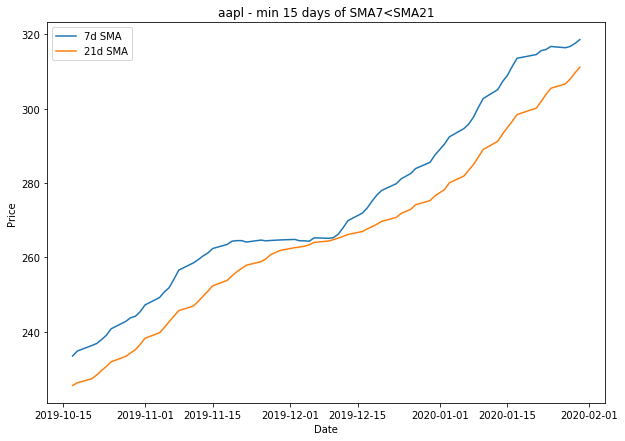

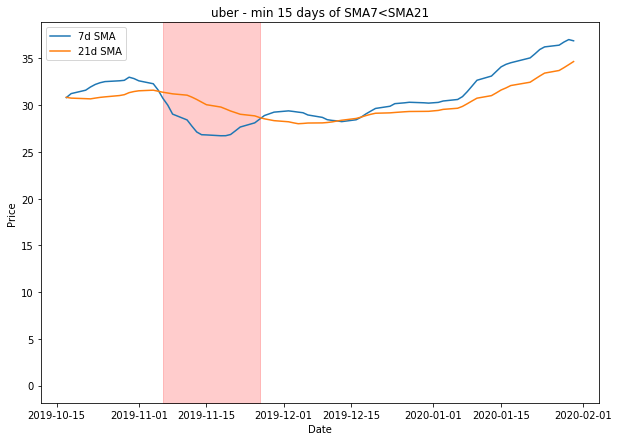

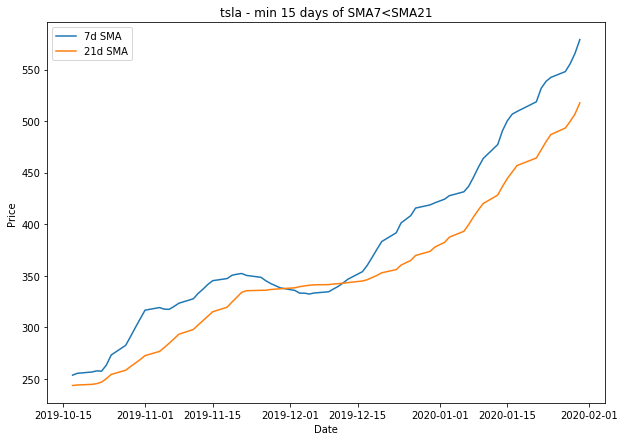

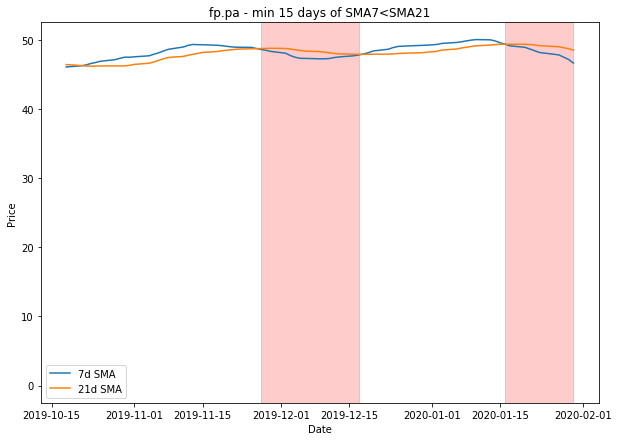

In [76]:
for tick in pf:
    df = ma_inv(tick.prices["Close"], name=tick.ticker, x=15, print_graph=True)

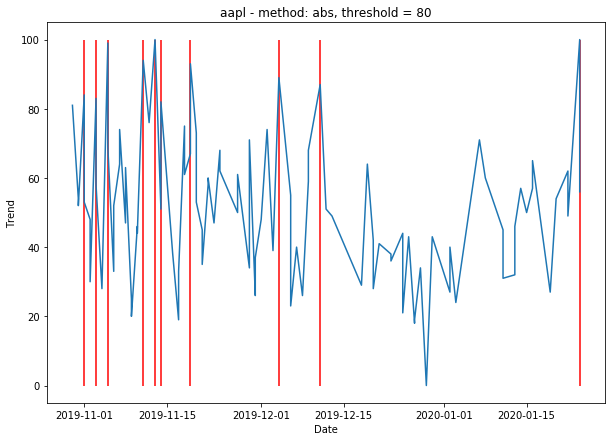

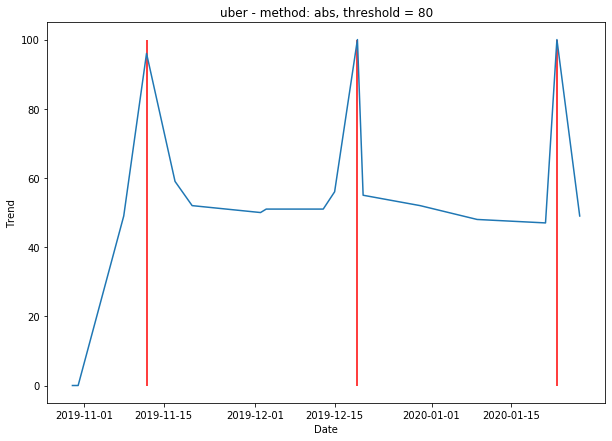

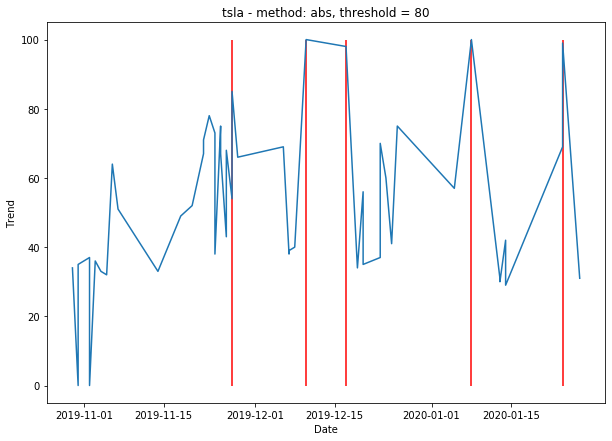

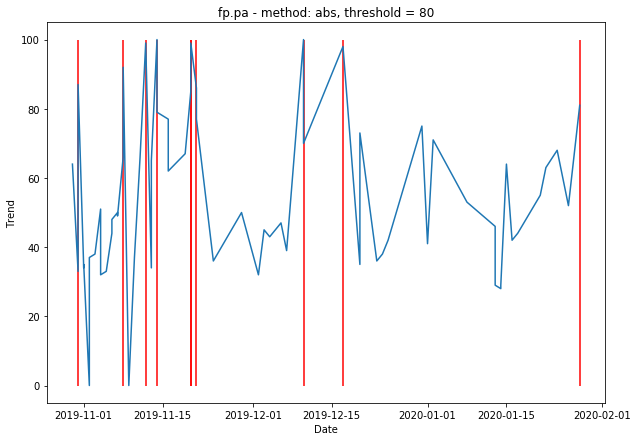

In [53]:
for tick in pf:
    _ = trend_spike(tick.trends, name=tick.ticker, print_graph=1, meth='abs', threshold=80)